In [1]:
import random
import time
from itertools import product, islice
from collections import defaultdict
from copy import deepcopy
from tqdm.auto import tqdm
import pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

import torch
import torch.nn as nn

### Definitions for translating between PyTorch and SciPy, since we will use SciPy's BFGS optimizer implementation

In [2]:
def get_func(model: nn.Module, loss_fn, x, y):
    def func(*p_tensors):
        assert len(list(model.parameters())) == len(p_tensors)
        assert type(model) is nn.Sequential
        i = 0
        z = x
        for module in model:
            if type(module) is nn.Linear:
                if module.bias is None:
                    z = nn.functional.linear(z, p_tensors[i], None)
                    i += 1
                else:
                    z = nn.functional.linear(z, p_tensors[i], p_tensors[i+1])
                    i += 2
            if type(module) in [nn.Tanh, nn.Sigmoid, nn.ReLU]:
                z = module(z)
        return loss_fn(z, y)
    return func

def hessian_autograd(model, loss_fn, x, y):
    H = torch.autograd.functional.hessian(get_func(model, loss_fn, x, y), tuple(model.parameters()))
    return H

def hvp_autograd(model, v, loss_fn, x, y):
    _, Hv = torch.autograd.functional.hvp(get_func(model, loss_fn, x, y), tuple(model.parameters()), v)
    return Hv

def decompose_hessian(hessian, lengths, shapes):
    H_matrix = torch.zeros(sum(lengths), sum(lengths))
    for i, j in product(range(len(shapes)), range(len(shapes))):
        i0, i1 = sum(lengths[:i+1]) - lengths[i], sum(lengths[:i+1])
        j0, j1 = sum(lengths[:j+1]) - lengths[j], sum(lengths[:j+1])
        H_matrix[i0:i1, j0:j1] = hessian[i][j].reshape(lengths[i], lengths[j])
    vals, vecs = torch.linalg.eigh(H_matrix)
    vs = []
    for i in range(sum(lengths)):
        vec = vecs[:, i]
        v = tuple(vec[sum(lengths[:i]):sum(lengths[:i+1])].reshape(shapes[i]) for i in range(len(lengths)))
        vs.append(v)
    return vals, vs

def dot_prod(u, v):
    assert len(u) == len(v)
    result = 0
    for i in range(len(u)):
        result += torch.sum(u[i] * v[i])
    return result.item()

rmse_loss_fn_torch = lambda x, y: torch.sqrt(torch.mean(torch.pow(x-y, 2)))
qmqe_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 4)), 1/4)
smse_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 6)), 1/6)
mse_loss_fn_torch = nn.MSELoss()

def lp_norm(p):
    def loss(x, y):
        return torch.pow(torch.mean(torch.pow(torch.abs(x-y), p)), 1/p)
    return loss

def dl_loss(epsilon):
    def loss(x, y):
        return torch.mean(0.5 * torch.log2(1 + torch.pow((x-y) / epsilon, 2)))
    return loss


def loss(param_vector, lengths, shapes, 
             mlp, loss_fn, x, y, device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lengths[i]]
        l += lengths[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    return loss_fn(mlp(x.to(device)), y).detach().cpu().numpy()

def gradient(param_vector, lengths, shapes, 
             mlp, loss_fn, x, y, device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lengths[i]]
        l += lengths[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    loss_fn(mlp(x.to(device)), y).backward()
    grads = []
    for param in mlp.parameters():
        grads.append(param.grad.detach().clone().cpu().numpy().flatten())
        param.grad = None
    mlp.zero_grad()
    return np.concatenate(grads)

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [4]:
device

'cuda:0'

### Create train and test set using a teacher network

In [5]:
x_i = np.random.uniform(low=-1, high=1, size=(100000, 1))
x_i = torch.from_numpy(x_i).to(device)
x_i_test = np.random.uniform(low=-1, high=1, size=(10000, 1))
x_i_test = torch.from_numpy(x_i_test).to(device)

teacher = nn.Sequential(
    nn.Linear(1, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1)
).to(device)

with torch.no_grad():
    y_i = teacher(x_i)
    y_i_test = teacher(x_i_test)

### Perform training run of first network

In [6]:
results = dict()

width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lengths = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lengths.append(len(param_np_flat))
    params.append(param_np_flat)
param_vector = np.concatenate(params)

results['train1'] = list()
results['test1'] = list()
results['times1'] = list()
def callback(xk):
    results['times1'].append(time.time())
    results['train1'].append(loss(xk, lengths, shapes, mlp, rmse_loss_fn_torch, x_i, y_i, device).item())
    results['test1'].append(loss(xk, lengths, shapes, mlp, rmse_loss_fn_torch, x_i_test, y_i_test, device).item())

results['start_time1'] = time.time()
result = optimize.minimize(loss,
                    param_vector, 
                    args=(lengths, shapes, mlp, mse_loss_fn_torch, x_i, y_i, device),
                    jac=gradient,
                    method='BFGS',
                    options={
                        'disp': True,
                        'gtol': 1e-60,
                        'maxiter': 25000,
        # #                                'finite_diff_rel_step': 1e-15
                    },
                    callback=callback
                ) 
mlp.zero_grad()
solution_params = [p.detach().clone() for p in mlp.parameters()]

# for j, p in enumerate(mlp.parameters()):
#     p.data = solution_params[j].clone()

# solution_params2 = [p.detach().clone() for p in mlp.parameters()]



         Current function value: 0.000000
         Iterations: 2454
         Function evaluations: 2886
         Gradient evaluations: 2874


In [7]:
with torch.no_grad():
    print(rmse_loss_fn_torch(mlp(x_i_test), y_i_test).item())

4.0960145066512555e-08


### Compute and visualize residual

In [8]:
with torch.no_grad():
    c = 1 / torch.mean(torch.abs(y_i - mlp(x_i))).item()
    yd_i = c * (y_i - mlp(x_i))

Text(0.5, 1.0, 'First residual in teacher-student setup, with BFGS optimizer')

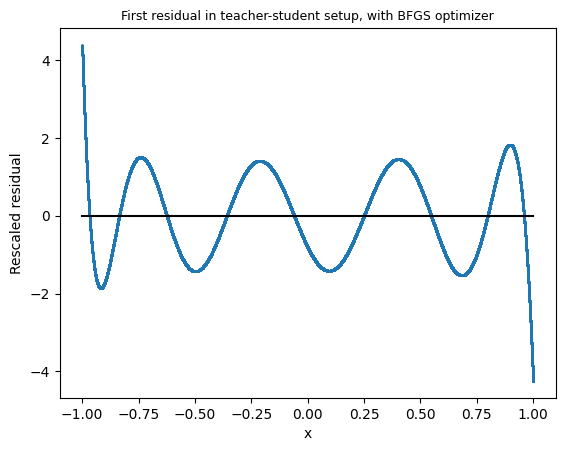

In [12]:
plt.scatter(x_i.detach().cpu().numpy(), yd_i.detach().cpu().numpy(), s=1)
plt.plot([x_i.min().item(), x_i.max().item()], [0, 0], color='black')
plt.ylabel("Rescaled residual")
plt.xlabel("x")
plt.title("First residual in teacher-student setup, with BFGS optimizer", fontsize=9)

### Train a second network on the residual

In [13]:
width = 20
mlp2 = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params2 = []
shapes2 = []
lengths2 = []
for param in mlp2.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes2.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lengths2.append(len(param_np_flat))
    params2.append(param_np_flat)
param_vector2 = np.concatenate(params2)

results['train3'] = list()
results['test3'] = list()
results['times3'] = list()
def callback(xk):
    """xk is the param vector for mlp2"""
    l = 0
    for i, param in enumerate(mlp2.parameters()):
        param_data = xk[l:l+lengths2[i]]
        l += lengths2[i]
        param_data_shaped = param_data.reshape(shapes2[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    results['times3'].append(time.time())
    results['train3'].append(rmse_loss_fn_torch(mlp(x_i) + (1/c)*mlp2(x_i), y_i).item())
    results['test3'].append(rmse_loss_fn_torch(mlp(x_i_test) + (1/c)*mlp2(x_i_test), y_i_test).item())

results['start_time3'] = time.time()
result = optimize.minimize(loss,
                    param_vector2, 
                    args=(lengths2, shapes2, mlp2, mse_loss_fn_torch, x_i, yd_i, device),
                    jac=gradient,
                    method='BFGS',
                    options={
                        'disp': True,
                        'gtol': 1e-60,
                        'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                    },
                    callback=callback
                    )
mlp2.zero_grad()

# boost_solution_params = [p.detach().clone() for p in mlp2.parameters()]

# for j, p in enumerate(mlp2.parameters()):
#     p.data = boost_solution_params[j].clone()





         Current function value: 0.000000
         Iterations: 12177
         Function evaluations: 13168
         Gradient evaluations: 13156


In [14]:
with torch.no_grad():
    print(rmse_loss_fn_torch(mlp(x_i_test) + (1/c)*mlp2(x_i_test), y_i_test).item())

3.166749748647018e-13


In [15]:
with torch.no_grad():
    yd2_i =  y_i - (mlp(x_i) + (1/c)*mlp2(x_i))

Text(0.5, 1.0, 'Second residual in teacher-student setup, with BFGS optimizer')

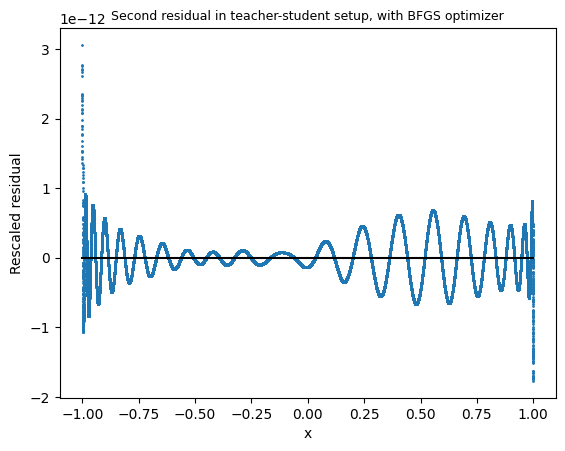

In [16]:
plt.scatter(x_i.detach().cpu().numpy(), yd2_i.detach().cpu().numpy(), s=1)
plt.plot([x_i.min().item(), x_i.max().item()], [0, 0], color='black')
plt.ylabel("Rescaled residual")
plt.xlabel("x")
plt.title("Second residual in teacher-student setup, with BFGS optimizer", fontsize=9)